In [242]:
import os
import csv  
import pdb
from multiprocessing import Pool

import numpy as np
import pandas as pd
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
from scipy.interpolate import RegularGridInterpolator
import scipy.ndimage
from scipy.linalg import cho_factor, cho_solve
from scipy.stats import kstest

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
#import celerite
import radvel

import rvsearch

import occur
from occur import Completeness, Hierarchy

%matplotlib inline

ImportError: cannot import name 'lngrid' from 'occur' (/Users/lee/Academics/Astronomy/Planets/CLSIII/occur.py)

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [2]:
sysprops = pd.read_csv('../CLSI/legacy_tables/system_props.csv')

In [3]:
specmatch = pd.read_csv('~/Academics/Astronomy/Planets/CLSI/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [4]:
objects = pd.read_csv('../CLSI/legacy_tables/planet_list.csv')
trends = pd.read_csv('../CLSI/legacy_tables/trend_list.csv')

## Sort the planets into real, new candidates, known.

In [5]:
objects_real   = objects.query('status != "N" and status != "A" and status != "R"').reset_index(drop=True)
objects_good   = objects_real.query('mass != "nan"').reset_index(drop=True)
planets_s      = objects_good.query('(status == "S" or status == "SS") and mass > 10').reset_index(drop=True)
planets        = objects_good.query('status != "S" and status != "SS"').reset_index(drop=True)
planets_old    = planets.query('status == "K"').reset_index(drop=True)
planets_new    = planets.query('status == "C" or status == "J"').reset_index(drop=True)

## How many stars that host small planets have linear or parabolic trends?

In [10]:
trend_names = np.unique(trends.hostname)
small_names = np.unique(planets.query('mass < 0.1 and hostname != "143761"').hostname)

In [11]:
[name for name in trend_names if name in small_names]

['156668', '45184']

### The 156668 trend is modeling out an activity alias, and the 45184 trend might be directly modeling activity.

## Inner super-Earths and outer gas giants

In [12]:
# HD 143761 has an inner giant and an outer small planet. Weirdo.
supers = planets.query('mass < 0.1 and hostname != "143761"').reset_index(drop=True)
supernames = np.unique(supers.hostname)
print(len(supers), len(np.unique(supers.hostname)))

42 28


In [13]:
outers = planets.query('mass >= 0.1 and hostname in @supernames and hostname != "143761"').reset_index(drop=True)
outernames = np.unique(outers.hostname) # and axis > 0.3

In [14]:
pairs = planets.query('hostname in @outernames and hostname != "143761"').reset_index(drop=True)
solos = planets.query('mass < 0.1 and not (hostname in @outernames) and hostname != "143761"')
pairnames = np.unique(pairs.hostname)
solonames = np.unique(solos.hostname)

In [15]:
giants = planets.query('mass >= 0.1')
giantnames = np.unique(giants.hostname)

## Preliminary statistics.

In [16]:
all_outers  = planets.query('mass >= 0.1 and axis > 0.23 and hostname != "143761"')
allouternames = list(all_outers.hostname)
inners = planets.query('mass < 0.1 and hostname in @allouternames and hostname != "143761"').reset_index(drop=True)

In [17]:
print(len(supers), 'small planets,', len(outers), 'outer companions,', len(outers)/len(supers))

42 small planets, 11 outer companions, 0.2619047619047619


In [18]:
print(len(np.unique(supers.hostname)), 'small planet systems,', len(np.unique(outers.hostname)), 
      'inner and outer systems,', len(np.unique(outers.hostname))/len(np.unique(supers.hostname)))

28 small planet systems, 8 inner and outer systems, 0.2857142857142857


In [19]:
print(len(all_outers), 'cold giants,', len(inners), 'inner companions,', len(inners)/len(all_outers))

111 cold giants, 13 inner companions, 0.11711711711711711


In [20]:
print(len(np.unique(all_outers.hostname)), 'cold giant systems,', len(np.unique(inners.hostname)), 
      'inner and outer systems,', len(np.unique(inners.hostname))/len(np.unique(all_outers.hostname)))

81 cold giant systems, 8 inner and outer systems, 0.09876543209876543


## Compare metallicities of all small-planet hosts and inner-outer pair hosts.

In [22]:
stellar_giants = specmatch.query('name in @giantnames')
stellar_supers = specmatch.query('name in @supernames')
stellar_solos  = specmatch.query('name in @solonames')
stellar_pairs  = specmatch.query('name in @pairnames')

In [23]:
print(len(stellar_giants), len(stellar_supers), len(stellar_solos), len(stellar_pairs))

96 28 20 8


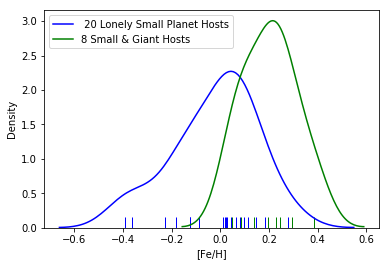

In [24]:
fig, ax = plt.subplots()

sns.distplot(stellar_solos.fe_c, rug=True, hist=False, kde=True, ax=ax, color='blue', \
             label=' {} Lonely Small Planet Hosts'.format(len(stellar_solos)))
sns.distplot(stellar_pairs.fe_c, rug=True, hist=False, kde=True, ax=ax, color='green', \
             label='{} Small & Giant Hosts'.format(len(stellar_pairs)))

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.legend(loc=2)
fig.savefig('plots/pair_solo_fe_histogram.pdf')

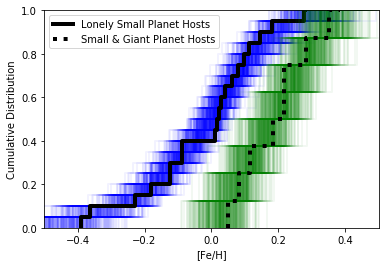

In [28]:
fig, ax = plt.subplots()

for i in np.arange(500):
    metals = np.random.normal(stellar_solos.fe_c, stellar_solos.fe_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=20*len(stellar_solos))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='blue', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(stellar_solos.fe_c, normed=True, bins=20*len(stellar_solos))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='Lonely Small Planet Hosts')


for i in np.arange(500):
    metals = np.random.normal(stellar_pairs.fe_c, stellar_pairs.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True)#bins=19
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(stellar_pairs.fe_c, normed=True)#bins=19
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='Small & Giant Planet Hosts')


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend()

fig.savefig('plots/metallicity_cumulative_lonely_pair.pdf', bbox_inches='tight')

In [26]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    solometals = np.random.normal(stellar_solos.fe_c, stellar_solos.fe_err_c)
    pairmetals = np.random.normal(stellar_pairs.fe_c, stellar_pairs.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(solometals, pairmetals) #kstest
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

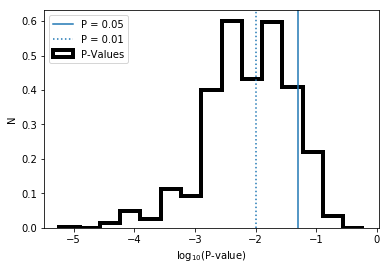

In [29]:
fig, ax = plt.subplots()
ax.hist(np.log10(probs), bins=15, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.legend()
fig.savefig('plots/pvalue_lonely_pair.pdf', bbox_inches='tight')

In [37]:
kolmogorov = scipy.stats.ks_2samp(stellar_solos.fe_c, stellar_pairs.fe_c)
print(kolmogorov[1])

0.01224012702273558


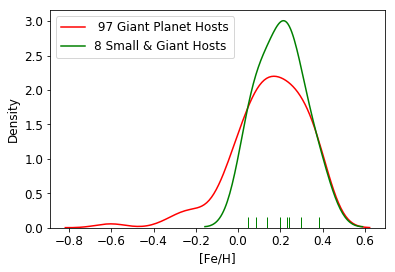

In [77]:
fig, ax = plt.subplots()

sns.distplot(stellar_giants.fe_c, rug=False, hist=False, kde=True, ax=ax, color='red', \
             label=' {} Giant Planet Hosts'.format(len(stellar_giants)))
sns.distplot(stellar_pairs.fe_c, rug=True, hist=False, kde=True, ax=ax, color='green', \
             label='{} Small & Giant Hosts'.format(len(stellar_pairs)))

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.legend(loc=2)
fig.savefig('plots/pair_solo_fe_histogram.pdf')

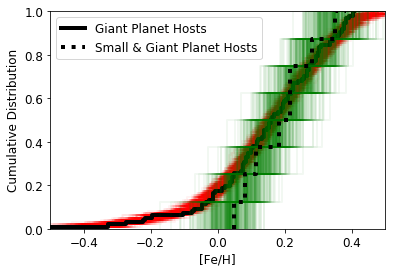

In [80]:
# np.insert(simple_counts, 0, simple_counts[0])
# np.insert(simple_counts, 0, 0)

fig, ax = plt.subplots()

for i in np.arange(500):
    metals = np.random.normal(stellar_giants.fe_c, stellar_giants.fe_err_c)
    hist, edges = np.histogram(metals, normed=True, bins=2*len(stellar_giants))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='red', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(stellar_giants.fe_c, normed=True, bins=2*len(stellar_giants))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='Giant Planet Hosts')


for i in np.arange(500):
    metals = np.random.normal(stellar_pairs.fe_c, stellar_pairs.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True)#bins=19
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(stellar_pairs.fe_c, normed=True)#bins=19
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='Small & Giant Planet Hosts')


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend()

fig.savefig('plots/metallicity_cumulative_giant_pair.pdf', bbox_inches='tight')

In [81]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    giantmetals = np.random.normal(stellar_giants.fe_c, stellar_giants.fe_err_c)
    pairmetals  = np.random.normal(stellar_pairs.fe_c, stellar_pairs.fe_err_c)
    kolmogorov  = scipy.stats.ks_2samp(giantmetals, pairmetals) 
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

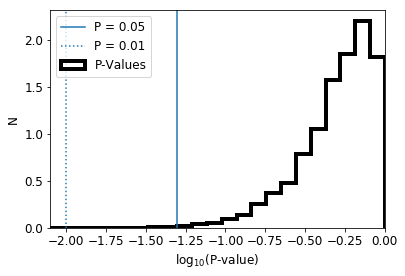

In [89]:
fig, ax = plt.subplots()
ax.hist(np.log10(probs), bins=23, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-2.1, 0])
ax.legend(loc=2)
fig.savefig('plots/pvalue_giant_pair.pdf', bbox_inches='tight')

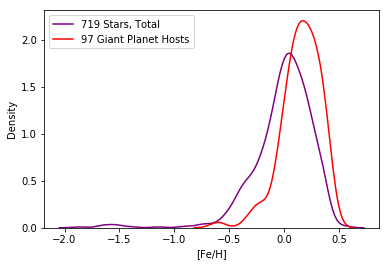

In [50]:
fig, ax = plt.subplots()

sns.distplot(specmatch.fe_c, rug=False, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Stars, Total'.format(len(specmatch)))
sns.distplot(stellar_giants.fe_c, rug=False, hist=False, kde=True, ax=ax, color='red', \
             label='{} Giant Planet Hosts'.format(len(stellar_giants)))

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.legend(loc=2)
fig.savefig('plots/all_giant_fe_histogram.pdf')

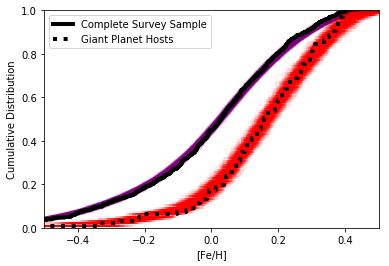

In [38]:
fig, ax = plt.subplots()

for i in np.arange(500):
    metals = np.random.normal(specmatch.fe_c, specmatch.fe_err_c)
    hist, edges = np.histogram(metals, normed=True, bins=2*len(specmatch))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    

hist, edges = np.histogram(specmatch.fe_c, normed=True, bins=2*len(specmatch))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', lw=4,
        label='Complete Survey Sample')


for i in np.arange(500):
    metals = np.random.normal(stellar_giants.fe_c, stellar_giants.fe_err_c)
    hist, edges = np.histogram(metals, normed=True, bins=2*len(stellar_giants))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='red', lw=2, alpha=0.05, label='_nolegend_')    
    
hist, edges = np.histogram(stellar_giants.fe_c, normed=True, bins=2*len(stellar_giants))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='Giant Planet Hosts')


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend()

fig.savefig('plots/metallicity_cumulative_all_giants.pdf', bbox_inches='tight')

In [39]:
kolmogorovs = []
probs = []
for i in np.arange(10**4):
    allmetals = np.random.normal(specmatch.fe_c, specmatch.fe_err_c)
    giantmetals = np.random.normal(stellar_giants.fe_c, stellar_giants.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(allmetals, giantmetals) 
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

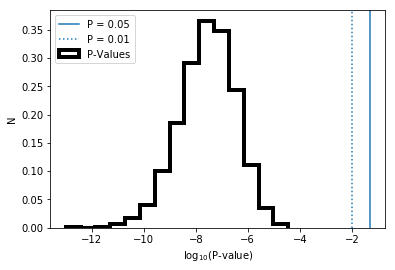

In [40]:
fig, ax = plt.subplots()
ax.hist(np.log10(probs), bins=15, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.legend()
fig.savefig('plots/pvalue_all_giants.pdf', bbox_inches='tight')

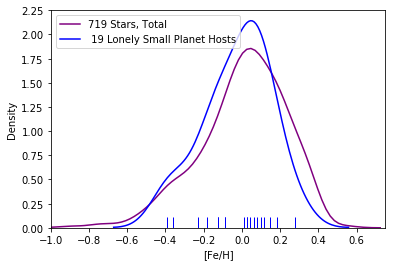

In [51]:
fig, ax = plt.subplots()

sns.distplot(specmatch.fe_c, rug=False, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Stars, Total'.format(len(specmatch)))
sns.distplot(stellar_solos.fe_c, rug=True, hist=False, kde=True, ax=ax, color='blue', \
             label=' {} Lonely Small Planet Hosts'.format(len(stellar_solos)))

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.set_xlim([-1, 0.75])
ax.legend(loc=2)
fig.savefig('plots/all_solosmall_fe_histogram.pdf')

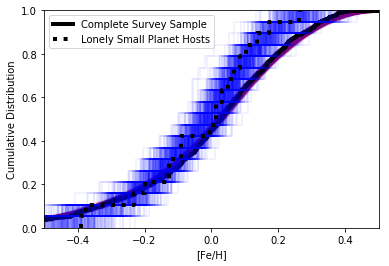

In [117]:
fig, ax = plt.subplots()

for i in np.arange(500):
    metals = np.random.normal(specmatch.fe_c, specmatch.fe_err_c)
    hist, edges = np.histogram(metals, normed=True, bins=2*len(specmatch))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    

hist, edges = np.histogram(specmatch.fe_c, normed=True, bins=2*len(specmatch))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', lw=4,
        label='Complete Survey Sample')


for i in np.arange(500):
    metals = np.random.normal(stellar_solos.fe_c, stellar_solos.fe_err_c)
    hist, edges = np.histogram(metals, normed=True, bins=2*len(stellar_solos))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='blue', lw=2, alpha=0.05, label='_nolegend_')    
    
hist, edges = np.histogram(stellar_solos.fe_c, normed=True, bins=2*len(stellar_solos))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='Lonely Small Planet Hosts')


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend()

In [42]:
kolmogorovs = []
probs = []
for i in np.arange(10**4):
    allmetals = np.random.normal(specmatch.fe_c, specmatch.fe_err_c)
    solometals = np.random.normal(stellar_solos.fe_c, stellar_solos.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(allmetals, solometals) 
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

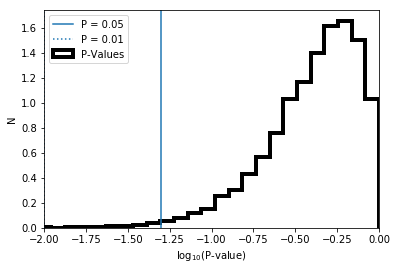

In [52]:
fig, ax = plt.subplots()
ax.hist(np.log10(probs), bins=25, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.legend(loc=2)
ax.set_xlim([-2, 0])
fig.savefig('plots/pvalue_all_lonely.pdf', bbox_inches='tight')

## Compare mass & eccentricity distributions of outer giant companions to all giants.

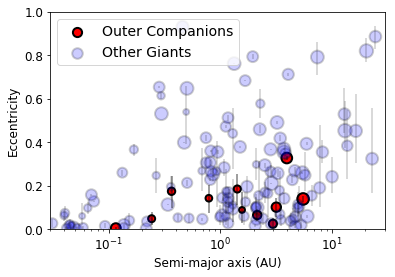

In [31]:
giants = planets.query('mass > 0.1')

fig, ax = plt.subplots()
#matplotlib.rcParams.update({'font.size': 1})
#plt.title('Axis and Eccentricity')
#plt.title('a < 5 AU, M > 0.1 MJup')
matplotlib.rcParams.update({'font.size': 14})

outies = pairs.query('mass >= 0.1')
outynames = list(np.unique(outies.hostname))
nouties = planets.query('mass >= 0.1 and hostname not in @outynames')

ax.scatter(outies.axis_med, outies.e_med, 
           s=list(30*np.log(30*outies.mass)), 
           c='red', edgecolors='black', 
           alpha=1, linewidth=2, 
           label='Outer Companions')
ax.vlines(outies.axis_med, outies.e_minus, outies.e_plus, 
          alpha=0.5, color='black', label='_nolegend_')

ax.scatter(nouties.axis_med, nouties.e_med, 
           s=list(30*np.log(30*nouties.mass)), 
           c='blue', edgecolors='black', 
           alpha=0.2, linewidth=2,
           label='Other Giants')
ax.vlines(nouties.axis_med, nouties.e_minus, nouties.e_plus, 
          alpha=0.2, color='black', label='_nolegend_')

ax.legend()
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])
ax.set_xscale('log')
fig.savefig('plots/axis_eccentricity_outies_ci.png', dpi=1000, bbox='tight')
fig.savefig('plots/axis_eccentricity_outies_ci.pdf', bbox='tight')

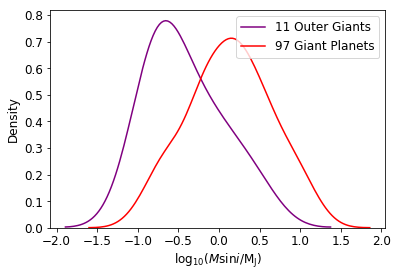

In [98]:
fig, ax = plt.subplots()

sns.distplot(np.log10(outies.mass), rug=False, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Outer Giants'.format(len(outies)))
sns.distplot(np.log10(giants.mass), rug=False, hist=False, kde=True, ax=ax, color='red', \
             label='{} Giant Planets'.format(len(stellar_giants)))
#ax.set_xscale('log')
ax.set_xlabel(r'log$_{10}$($M$sin$i$/M$_{\mathrm{J}}$)')
ax.set_ylabel('Density')
ax.legend(loc=1)
fig.savefig('plots/outie_giant_mass_kde.pdf')

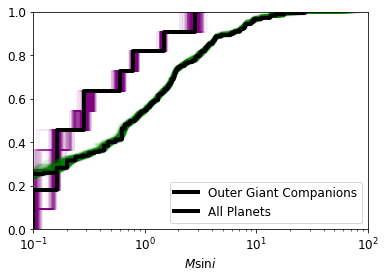

In [69]:
fig, ax = plt.subplots()

for i in np.arange(500):
    masses = np.random.normal(outies.mass_med, 0.5*(outies.mass_plus - outies.mass_minus))
    hist, edges = np.histogram(masses, normed=True, bins=4*len(outies))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    

hist, edges = np.histogram(outies.mass_med, normed=True, bins=4*len(outies))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', lw=4,
        label='Outer Giant Companions')

for i in np.arange(500):
    masses = np.random.normal(planets.mass_med, 0.5*(planets.mass_plus - planets.mass_minus))
    hist, edges = np.histogram(masses, normed=True, bins=4*len(planets))
    chist = np.cumsum(hist)/np.sum(hist)
    x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

hist, edges = np.histogram(planets.mass_med, normed=True, bins=4*len(planets))
chist = np.cumsum(hist)/np.sum(hist)
x = np.vstack((edges, np.roll(edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((chist, chist)).T.flatten(), 0, 0), color='black', lw=4,
        label='All Planets')

ax.set_xscale('log')
ax.set_xlim([0.1, 100])
ax.set_ylim([0, 1])
ax.set_xlabel(r'$M$sin$i$')
ax.legend()

## Get diggity with some occurrence work.

In [35]:
def lngrid(min_a, max_a, min_M, max_M, resa, resm):
    lna1 = np.log(min_a)
    lna2 = np.log(max_a)
    lnM1 = np.log(min_M)
    lnM2 = np.log(max_M)
    
    dlna = (lna2 - lna1)/resa
    dlnM = (lnM2 - lnM1)/resm

    bins = []
    for i in np.arange(int(resa)):
        for j in np.arange(int(resm)):
            bins.append([[lna1 + i*dlna, lna1 + (i+1)*dlna], 
                         [lnM1 + j*dlnM, lnM1 + (j+1)*dlnM]])
            
    return np.array(bins)

In [37]:
recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)

In [35]:
samples_all = pd.read_csv('../legacy_samples/samples_all_1000.csv').sample(500).reset_index(drop=True)
good_cols = [col for col in samples_all.columns if '_a' in col or '_M' in col]
samples_all = samples_all[good_cols]
samples_med = samples_all.median()
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

# Trim out planets that don't belong in each sample.
columns_outers = [col for col in samples_all.columns if col[:-2] in list(supers.hostname)]
columns_small = [col for col in samples_all.columns if col[:-2] in list(all_outers.hostname)]
columns_good = []
for planet in planetnames:
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    if (samples_med[a_col] > 0.02) and (samples_med[M_col] > 0.09):
        columns_good.append(a_col)
        columns_good.append(M_col)
        
samples_all = samples_all[columns_good]

for col in columns_good:
    if '_M' in col:
        samples_all[col] *= 317.8

In [60]:
allbins = lngrid(0.03, 30., 30., 6000, 11, 1) 
hierarchical_one = Hierarchy(samples_all, completey_all, bins=allbins)
hierarchical_one.max_like()

In [68]:
hierarchical_one.sample(parallel=True, gp=False)

100%|██████████| 1000/1000 [45:39<00:00,  2.74s/it]


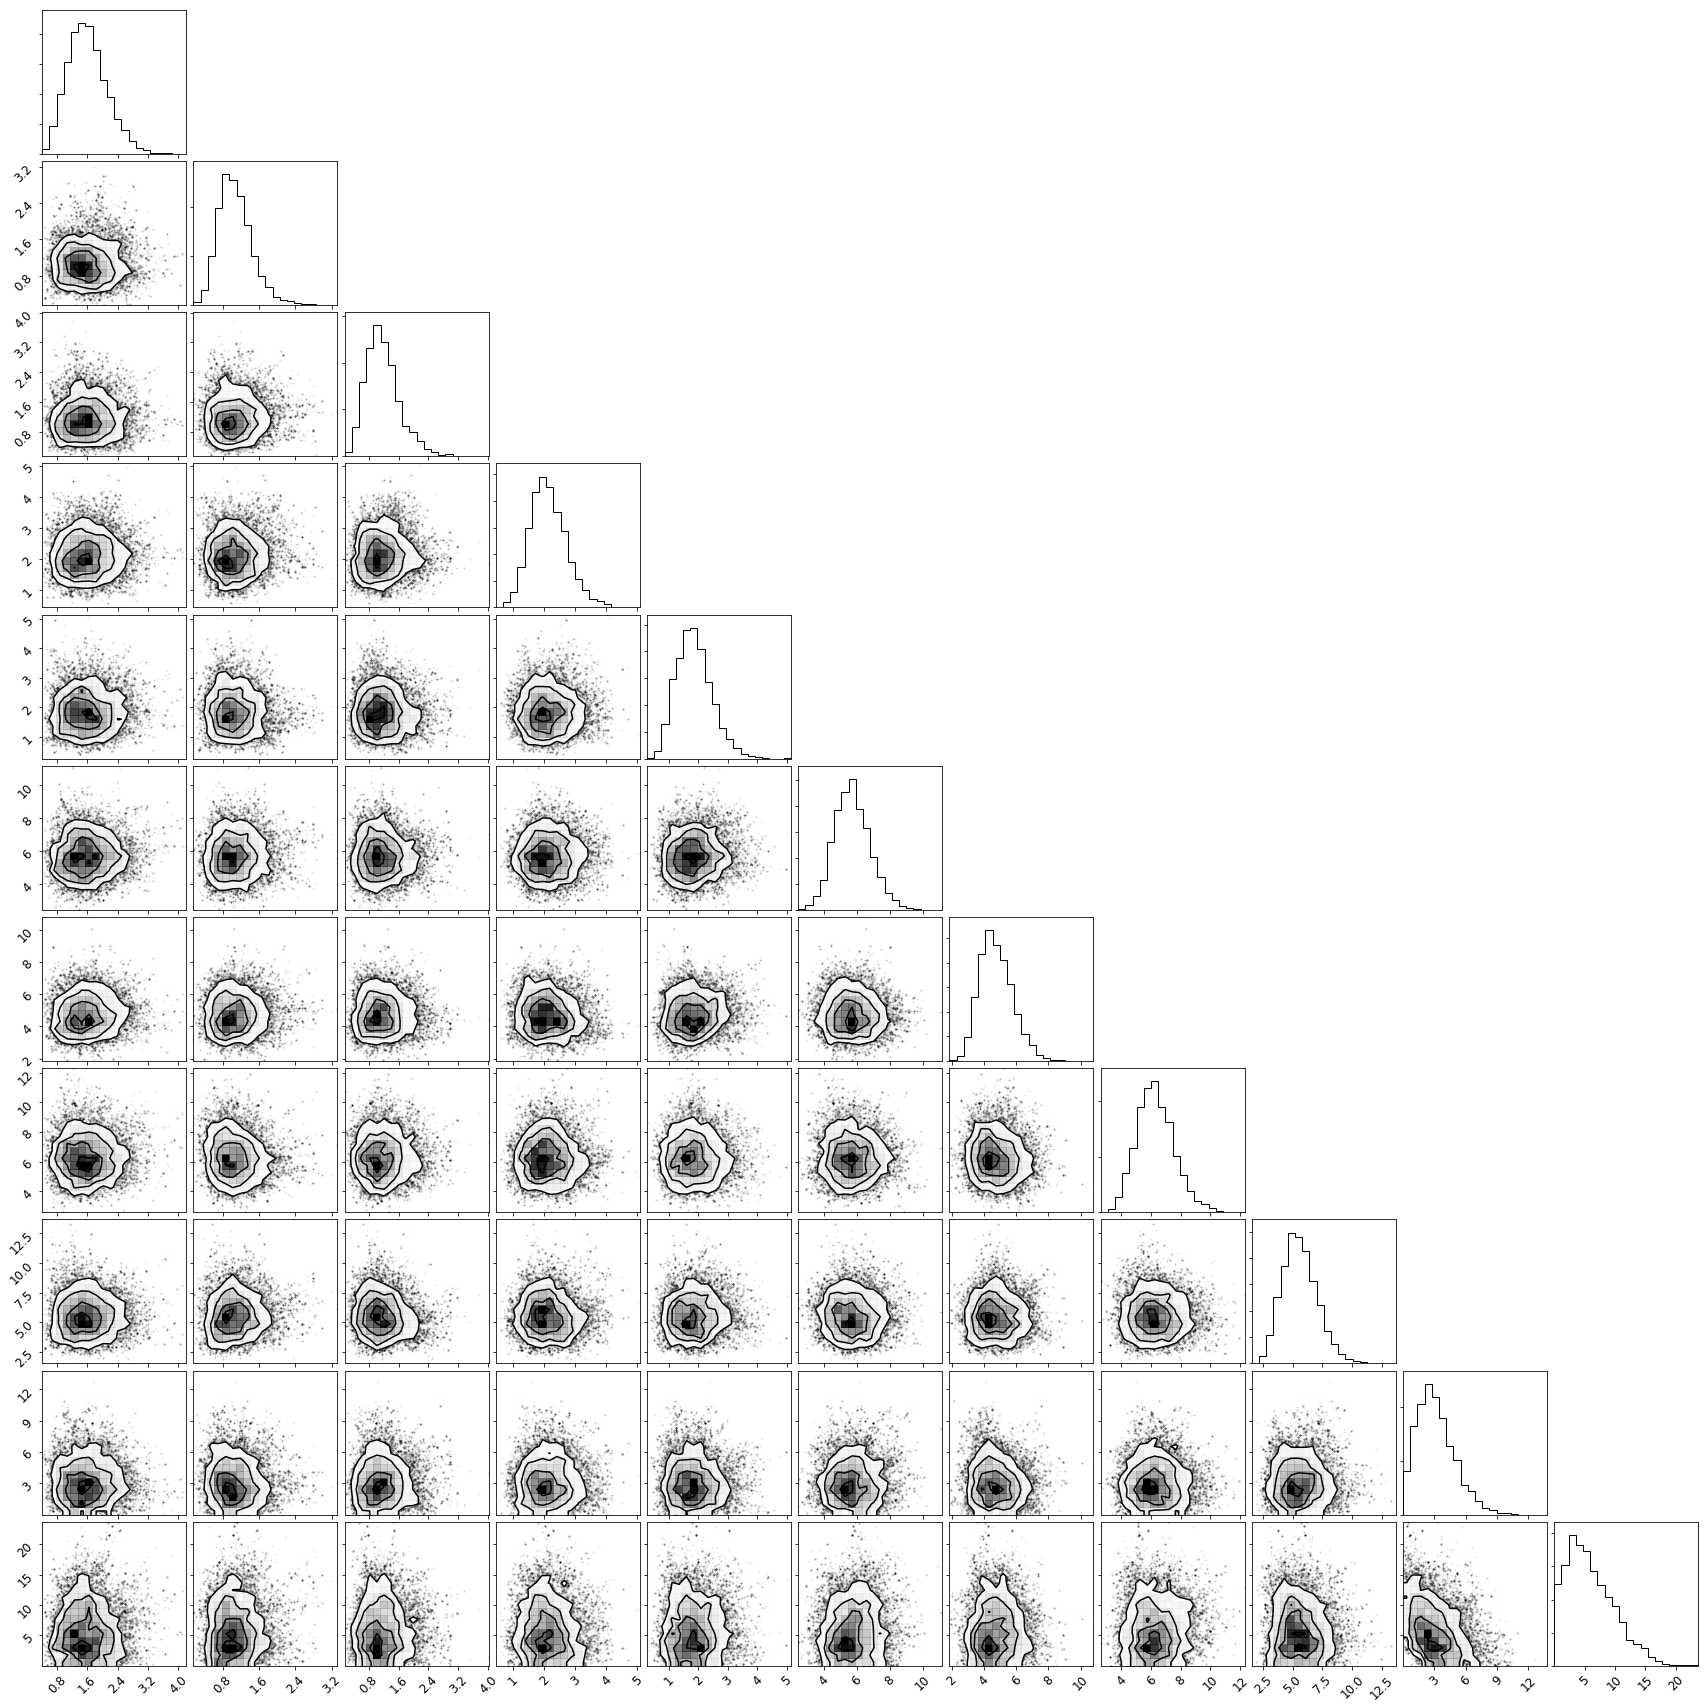

In [73]:
fig = corner.corner(hierarchical_one.chains[10000:]*hierarchical_one.bin_areas[0][0]*(100/719))
fig.savefig('corner_11x1_1014.pdf')

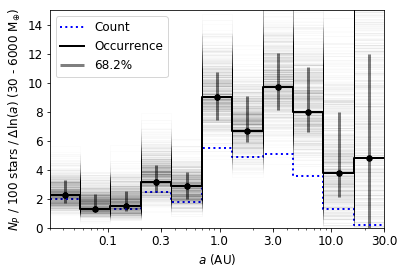

In [64]:
matplotlib.rcParams.update({'font.size': 12})
chains_db = pd.read_csv('occur_chains_11x1_1014.csv')

binwidth = allbins[0][0][1] - allbins[0][0][0]

# Do simple counting.
simple_counts = []
for n in np.arange(hierarchical_one.nbins):
    a1 = np.exp(allbins[n][0][0])
    a2 = np.exp(allbins[n][0][1])
    npl = len(planets.query('mass >= 0.1 and axis >= @a1 and axis < @a2'))
    simple_counts.append(npl)    
simple_counts = np.array(simple_counts)*(100/719)/binwidth

a_chains = np.empty((0, len(chains_db)))
for n in np.arange(hierarchical_one.nbins):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0)
a_chains *= hierarchical_one.bin_areas[0][0]*(100/719)/binwidth

# Record modes & medians.
a_medians = np.median(a_chains, axis=1)
a_sqvars  = np.std(a_chains, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(hierarchical_one.nbins):
    chains = np.array([chains_db['gamma{}'.format(n)]])*hierarchical_one.bin_areas[0][0]*(100/719)
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)/binwidth
a_159 = np.array(a_159)/binwidth
a_841 = np.array(a_841)/binwidth
a_682 = np.array(a_682)/binwidth

#pdb.set_trace()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($a$) (30 - 6000 $\mathrm{M_{\oplus}}$)')
ax.set_xlim([np.exp(hierarchical_one.lna_edges[0]), np.exp(hierarchical_one.lna_edges[-1])])
ax.set_ylim([0, 15])
lnaw = hierarchical_one.lna_edges[1] - hierarchical_one.lna_edges[0]

# Plot just-counting, no-completeness histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_one.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='black', s=30, label='_nolegend_')#label='Occurrence mode & CI')
ax.vlines(np.exp(hierarchical_one.lna_edges[:-2] + 0.5*lnaw), a_159[:-1],
          a_841[:-1], alpha=0.5, color='black', lw=3, label='68.2%')
# Show CI from 0 to 68.2 for the last bin.
ax.vlines(np.exp(hierarchical_one.lna_edges[-2] + 0.5*lnaw), 0,
          a_682[-1], alpha=0.5, color='black', lw=3, label='_nolegend_')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='black', lw=2, label='Occurrence')

for i in np.arange(1000):
    ax.step(np.insert(np.exp(hierarchical_one.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_one.lna_edges[0])), 
            np.insert(a_chains[:, np.random.randint(0, 10000)], 0, a_medians[0]), 
            color='black', lw=1, alpha=0.01, label='_nolegend_')
 
ax.legend(loc=2) 

#fig.savefig('hist_11x1_1014_fancy_mode.png', dpi=1000, bbox_inches='tight')
#fig.savefig('hist_11x1_1014_fancy_mode.pdf', bbox_inches='tight')

In [31]:
twobins = lngrid(0.03, 30., 30., 317.8*20, 11, 2) 
hierarchical_two = Hierarchy(samples_all, completey_all, bins=twobins)
hierarchical_two.max_like()

In [82]:
np.exp(twobins)[1]

array([[3.00000000e-02, 5.62145227e-02],
       [4.36669211e+02, 6.35600000e+03]])

In [32]:
hierarchical_two.sample(parallel=True, gp=False)

100%|██████████| 1000/1000 [1:24:12<00:00,  5.05s/it]


In [63]:
chains_db = pd.read_csv('occur_chains_11x2.csv')
a_chains = np.empty((0, len(chains_db)))
for n in np.arange(11):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]) + \
                                   np.array([chains_db['gamma{}'.format(n+11)]]), axis=0) 
a_chains *= hierarchical_two.bin_areas[0][0]*(100/719)/binwidth
a_chains.shape

(11, 79200)

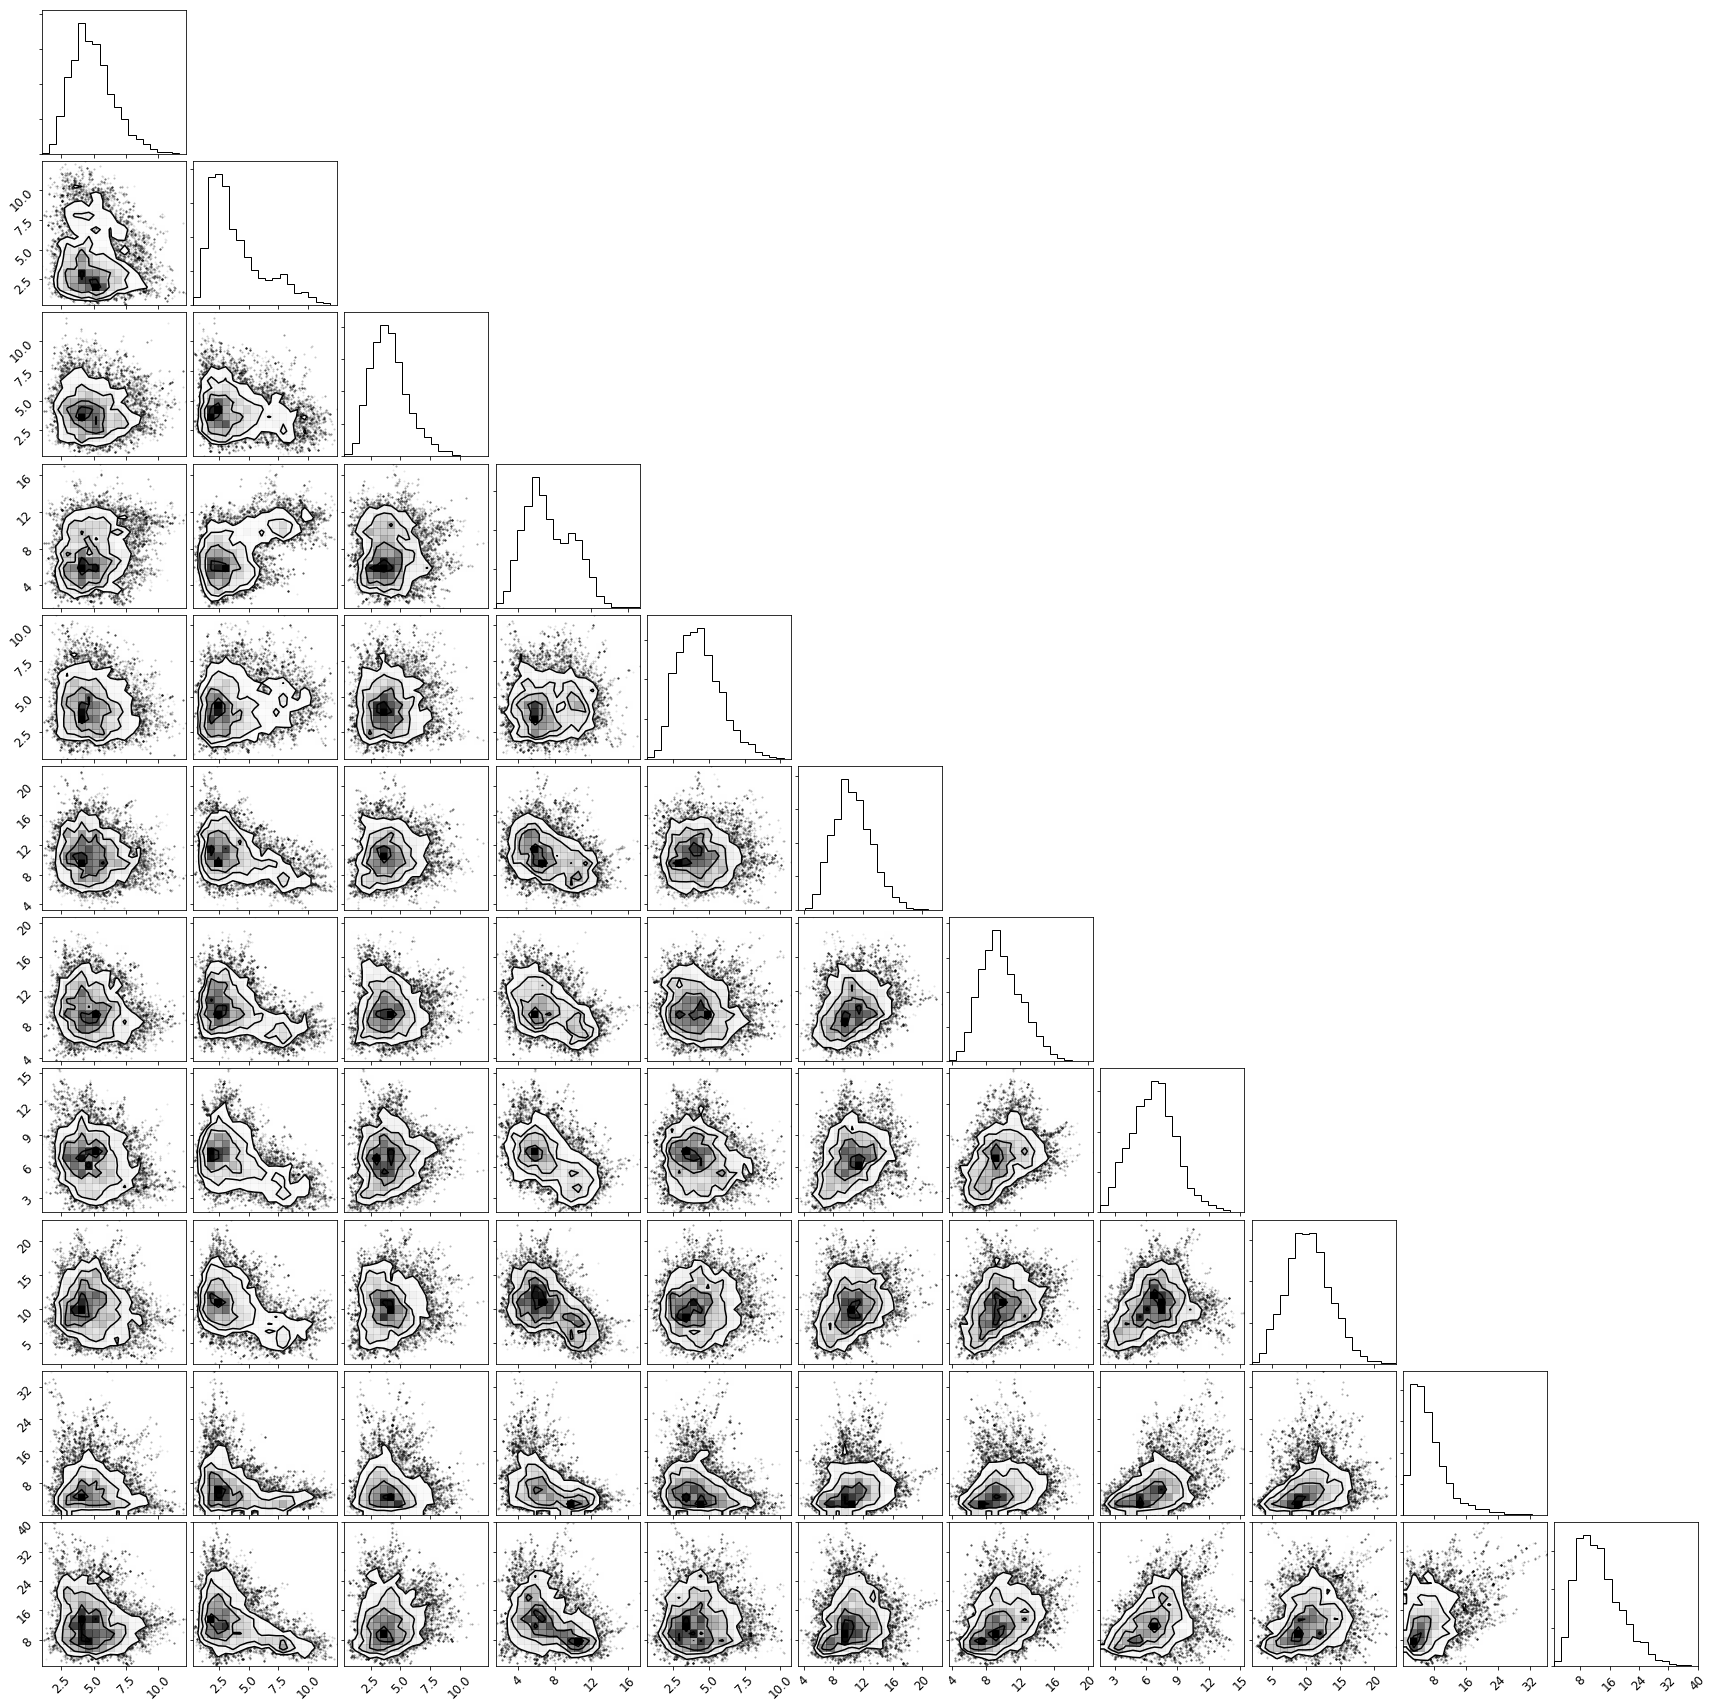

In [66]:
fig = corner.corner(a_chains.T[30000:])
fig.savefig('plots/twobins_corner.pdf')

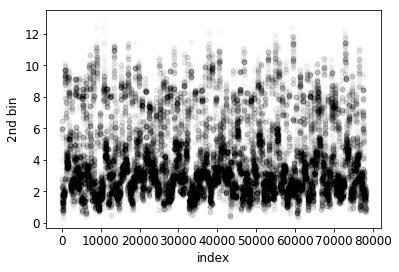

In [71]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(a_chains.T[1000:, 1])), a_chains.T[1000:, 1], alpha=0.01, color='black')
ax.set_xlabel('index')
ax.set_ylabel('2nd bin')
fig.savefig('2nd_bin_timeseries.pdf')

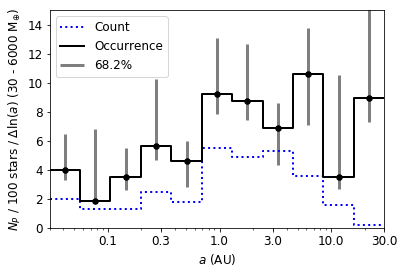

In [58]:
allbins = lngrid(0.03, 30., 30., 6000, 11, 1) 

matplotlib.rcParams.update({'font.size': 12})
chains_db = pd.read_csv('occur_chains_11x2.csv')

binwidth = twobins[0][0][1] - twobins[0][0][0]

# Do simple counting.
simple_counts = []
for n in np.arange(11):
    a1 = np.exp(allbins[n][0][0])
    a2 = np.exp(allbins[n][0][1])
    npl = len(planets.query('mass >= 0.1 and axis >= @a1 and axis < @a2'))
    simple_counts.append(npl)    
simple_counts = np.array(simple_counts)*(100/719)/binwidth

a_chains = np.empty((0, len(chains_db)))
for n in np.arange(11):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]) + \
                                   np.array([chains_db['gamma{}'.format(n+11)]]), axis=0) 
a_chains *= hierarchical_two.bin_areas[0][0]*(100/719)/binwidth

# Record modes & medians.
a_medians = np.median(a_chains, axis=1)
a_sqvars  = np.std(a_chains, axis=1)
a_modes = []
a_159 = []
a_841 = []
a_682 = []

for n in np.arange(11):
    chains = a_chains[n]
    hist, bin_edges = np.histogram(chains, bins=40, range=(np.percentile(chains, 2), np.percentile(chains, 95)))
    a_modes.append(bin_edges[np.argmax(hist)])
    a_159.append(np.percentile(chains, 15.9))
    a_841.append(np.percentile(chains, 84.1))
    a_682.append(np.percentile(chains, 68.2))
a_modes = np.array(a_modes)
a_159 = np.array(a_159)
a_841 = np.array(a_841)
a_682 = np.array(a_682)


fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xticks((0.1, 0.3, 1, 3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$N_P$ / 100 stars / $\Delta$ln($a$) (30 - 6000 $\mathrm{M_{\oplus}}$)')

ax.set_xlim([np.exp(hierarchical_two.lna_edges[0]), np.exp(hierarchical_two.lna_edges[-1])])
ax.set_ylim([0, 15])
lnaw = hierarchical_two.lna_edges[1] - hierarchical_two.lna_edges[0]

# Plot just-counting, no-completeness histogram.
ax.step(np.insert(np.exp(hierarchical_two.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_two.lna_edges[0])), 
        np.insert(simple_counts, 0, simple_counts[0]), lw=2, c='blue', linestyle=':', label='Count')

# Plot mode & 68.2% CI.
ax.scatter(np.exp(hierarchical_two.lna_edges[:-1] + 0.5*lnaw), a_modes,
           color='black', s=30, label='_nolegend_')
ax.vlines(np.exp(hierarchical_two.lna_edges[:-1] + 0.5*lnaw), a_159,
          a_841, alpha=0.5, color='black', lw=3, label='68.2%')

# Plot occurrence histogram.
ax.step(np.insert(np.exp(hierarchical_two.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_two.lna_edges[0])), 
        np.insert(a_modes, 0, a_modes[0]), color='black', lw=2, label='Occurrence')

#for i in np.arange(1000):
#    ax.step(np.insert(np.exp(hierarchical_two.lna_edges[:-1] + lnaw), 0, np.exp(hierarchical_two.lna_edges[0])), 
#            np.insert(a_chains[:, np.random.randint(0, 10000)], 0, a_medians[0]), 
#            color='black', lw=1, alpha=0.01, label='_nolegend_')
 
ax.legend(loc=2) 
#fig.savefig('plots/hist_11x2_1014_fancy_mode.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/hist_11x2_1014_fancy_mode.pdf', bbox_inches='tight')

In [38]:
recoveries_small = pd.read_csv('../recovery_files/recoveries_small_earth.csv')
completey_small  = Completeness(recoveries_small)
completey_small.completeness_grid([0.01, 40], [2, 9000])

recoveries_outer = pd.read_csv('../recovery_files/recoveries_outer_earth.csv')
completey_outer  = Completeness(recoveries_outer)
completey_outer.completeness_grid([0.01, 40], [2, 9000])

recoveries_pairs = pd.read_csv('../recovery_files/recoveries_small_and_outer_earth.csv')
completey_pairs  = Completeness(recoveries_pairs)
completey_pairs.completeness_grid([0.01, 40], [2, 9000])

recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)
completey_all.completeness_grid([0.01, 40], [2, 9000])

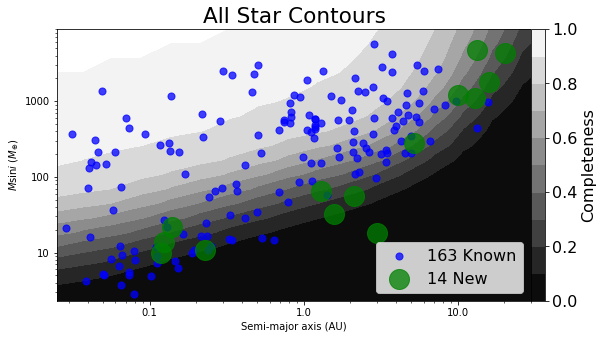

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_all.grid[0], completey_all.grid[1],
                 completey_all.grid[2], 10, cmap=plt.cm.gray)

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('All Star Contours')
ax.scatter(planets_old.axis, 317.8*planets_old.mass, c='b', s=50, alpha=0.75, 
           label='{} Known'.format(len(planets_old)))
ax.scatter(planets_new.axis, 317.8*planets_new.mass, s=400, c='g', alpha=0.75, 
           label='{} New'.format(len(planets_new)))

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([2.3, 9000])

ymin, ymax = ax.get_ylim()

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=4)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/all_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/all_contours.pdf', bbox_inches='tight')

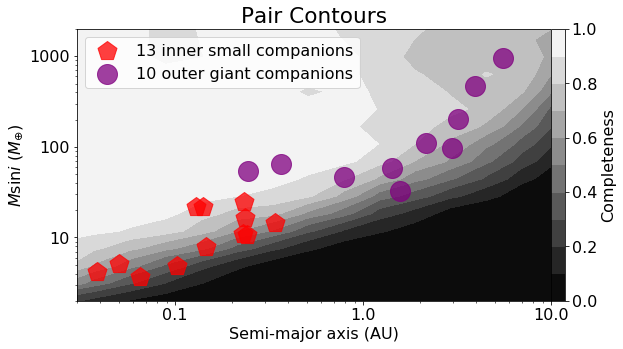

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_pairs.grid[0], completey_pairs.grid[1],
                 completey_pairs.grid[2], 10, cmap=plt.cm.gray)

pair_outer = outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Pair Contours')

ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giant companions'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 10])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/pair_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/pair_contours.pdf', bbox_inches='tight')

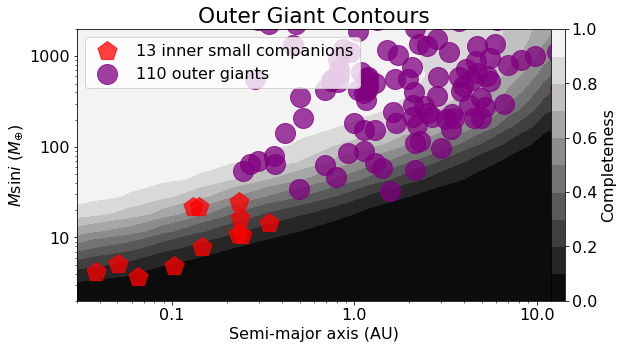

In [92]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_outer.grid[0], completey_outer.grid[1],
                 completey_outer.grid[2], 10, cmap=plt.cm.gray)

pair_outer = all_outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Outer Giant Contours')

ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giants'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 12])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
#ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/pair_all_outers.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/pair_all_outers.pdf', bbox_inches='tight')

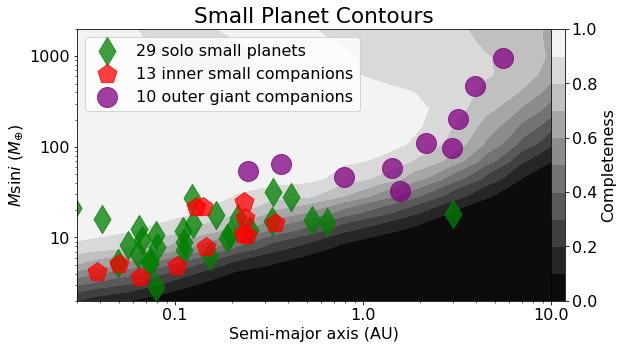

In [94]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_small.grid[0], completey_small.grid[1],
                 completey_small.grid[2], 10, cmap=plt.cm.gray)

pair_outer = outers.query('axis > 0.23')
pair_inner = supers.query('hostname in @outernames')

matplotlib.rcParams.update({'font.size': 18})
ax.set_title('Small Planet Contours')
ax.scatter(solos.axis, 317.8*solos.mass, c='g', s=400, alpha=0.75, 
           label='{} solo small planets'.format(len(solos)), marker='d')
ax.scatter(pair_inner.axis, 317.8*pair_inner.mass, c='r', s=400, alpha=0.75, 
           label='{} inner small companions'.format(len(pair_inner)), marker='p')
ax.scatter(pair_outer.axis, 317.8*pair_outer.mass, s=400, c='purple', alpha=0.75, 
           label='{} outer giant companions'.format(len(pair_outer)))
ax.set_xlim([3*10**-2, 10])
ax.set_ylim([2, 2000])

ymin, ymax = ax.get_ylim()
#ax2.set_ylim((ymin/317.8,ymax/317.8))
#ax2.plot([],[])

matplotlib.rcParams.update({'font.size': 16})
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
#ax2.set_ylabel(r'$M$sin$i$ ($M_J$)')
ax.legend(loc=2)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/small_planet_contours.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/small_planet_contours.pdf', bbox_inches='tight')

In [ ]:
pair_outer

## Make sampling dataframes for planet subsets.

In [49]:
samples_all = pd.read_csv('../legacy_samples/samples_all_joker.csv').sample(500).reset_index(drop=True)
samples_med = samples_all.median()

columns = [col for col in samples_all.columns if ('_M' in col or '_a' in col)]
samples_all = samples_all[columns]
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

columns_outers     = []
columns_outers_all = []
columns_small      = []
for planet in planetnames:
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    if (samples_med[a_col] > 0.2) and (samples_med[M_col] > 0.08) and planet[:-2] in list(supers.hostname):
        columns_outers.append(a_col)
        columns_outers.append(M_col)
    if (samples_med[a_col] > 0.2) and (samples_med[M_col] > 0.08):
        columns_outers_all.append(a_col)
        columns_outers_all.append(M_col)
    if samples_med[M_col] < 0.11 and planet[:-2] in list(all_outers.hostname):
        columns_small.append(a_col)
        columns_small.append(M_col)

samples_small = samples_all[columns_small]
for col in columns_small:
    if '_M' in col:
        samples_small[col] *= 317.8
        
samples_outers = samples_all[columns_outers]
for col in columns_outers:
    if '_M' in col:
        samples_outers[col] *= 317.8
        
samples_outers_all = samples_all[columns_outers_all]
for col in columns_outers_all:
    if '_M' in col:
        samples_outers_all[col] *= 317.8

In [50]:
num_inner_hosts = len(np.unique(supers.hostname))
print(num_inner_hosts)

28


In [42]:
outerbins = lngrid(0.23, 10., 30., 2000, 4, 4) 
hierarchical_outer = Hierarchy(samples_outers, completey_small, bins=outerbins)
hierarchical_outer.max_like()

In [56]:
hierarchical_outer.sample()

100%|██████████| 1000/1000 [10:38<00:00,  1.57it/s]


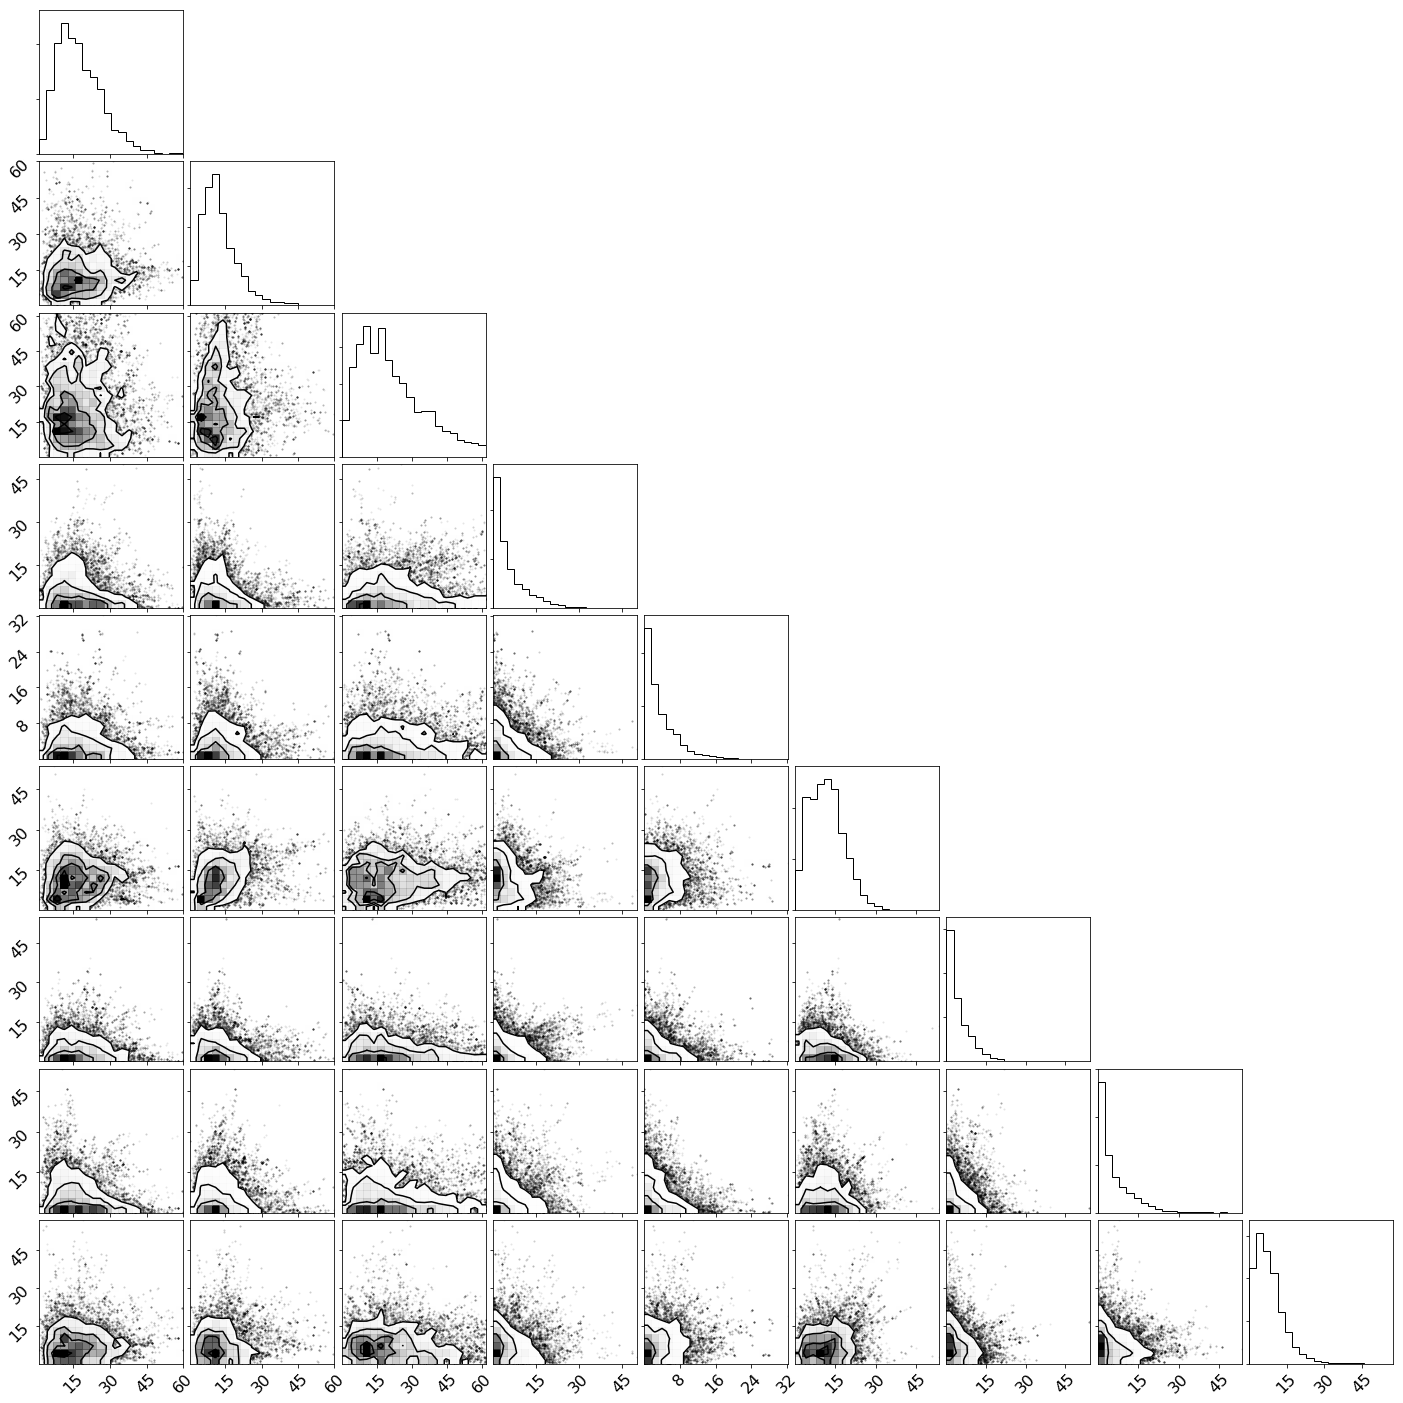

In [57]:
chains_db = pd.read_csv('occur_chains_outer_3x3.csv')
a_chains = np.empty((0, len(chains_db)))
for n in np.arange(len(chains_db.columns) - 1):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0) 
a_chains *= hierarchical_outer.bin_areas[0][0]*(100/num_inner_hosts)

fig = corner.corner(a_chains.T)
fig.savefig('plots/corner_outer_3x3.pdf')

In [147]:
outerbins = lngrid(0.23, 10., 30., 2000, 4, 4) 
hierarchical_outer_all = Hierarchy(samples_outers_all, completey_all, bins=outerbins)
hierarchical_outer_all.max_like()

In [148]:
hierarchical_outer_all.sample(parallel=True)

100%|██████████| 1000/1000 [58:54<00:00,  3.53s/it]


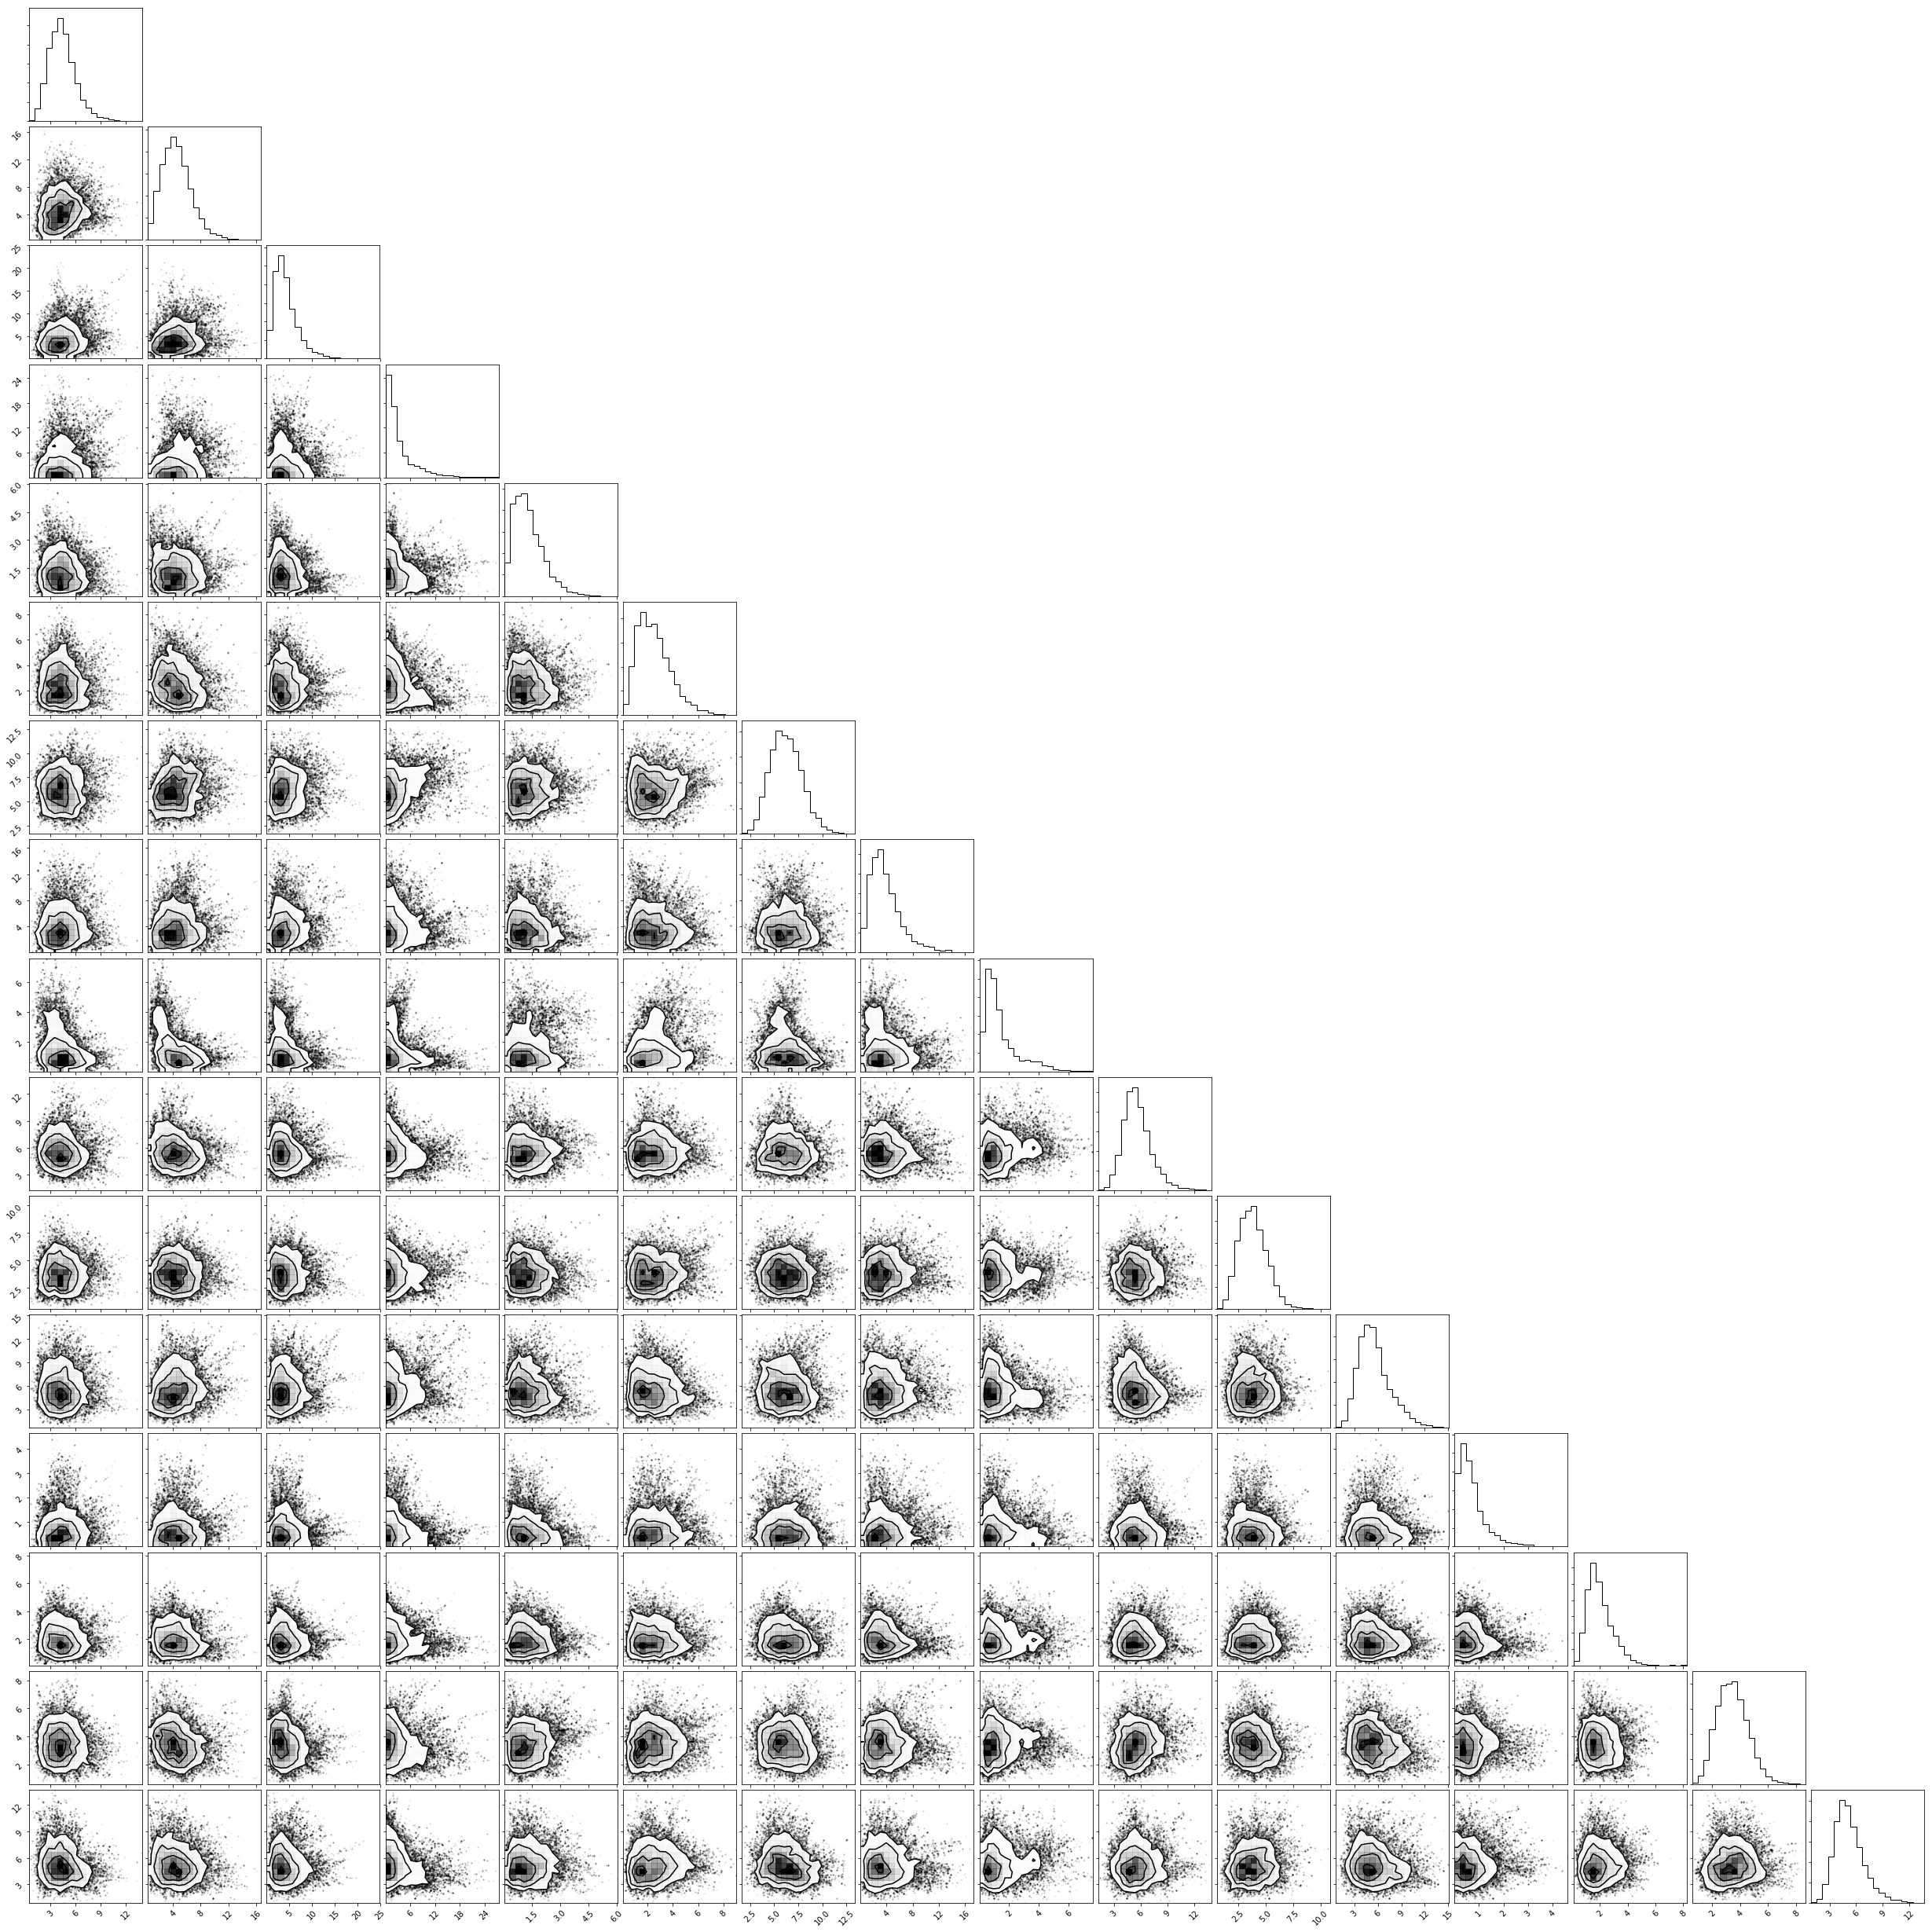

In [149]:
chains_db = pd.read_csv('occur_chains.csv')
a_chains = np.empty((0, len(chains_db)))
for n in np.arange(len(chains_db.columns) - 1):
    a_chains = np.append(a_chains, np.array([chains_db['gamma{}'.format(n)]]), axis=0) 
a_chains *= hierarchical_outer.bin_areas[0][0]*(100/719)

fig = corner.corner(a_chains.T)
fig.savefig('plots/corner_outer_all_4x4.pdf')

## Extract percentiles from posteriors, reshape for grid plots.

In [221]:
modes     = np.zeros([4, 4])
sixtys    = np.zeros([4, 4])
quartiles = np.zeros([4, 4, 3])
zeros     = np.zeros([4, 4], dtype=bool)

In [226]:
for n in np.arange(16):
    quartiles[np.mod(n, 4), np.floor_divide(n, 4), 0] = np.percentile(a_chains[n], 15.9)
    quartiles[np.mod(n, 4), np.floor_divide(n, 4), 1] = np.percentile(a_chains[n], 50.0)
    quartiles[np.mod(n, 4), np.floor_divide(n, 4), 2] = np.percentile(a_chains[n], 84.1)
    sixtys[np.mod(n, 4), np.floor_divide(n, 4)]       = np.percentile(a_chains[n], 68.2)
    
    hist, bin_edges = np.histogram(a_chains[n], bins=25, range=(np.percentile(a_chains[n],0.1), 
                                                                np.percentile(a_chains[n],68.3)))
    modes[np.mod(n, 4), np.floor_divide(n, 4)] = bin_edges[np.argmax(hist)]
    if modes[np.mod(n, 4), np.floor_divide(n, 4)] < quartiles[np.mod(n, 4), np.floor_divide(n, 4), 0]:
        zeros[np.mod(n, 4), np.floor_divide(n, 4)] = True


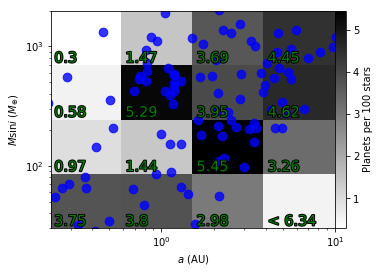

In [237]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.23, 10])
ax.set_ylim([30, 2000])
ax.set_xlabel(r'$a$ (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')

X = np.unique(np.exp(outerbins[:, 0]))
Y = np.unique(np.exp(outerbins[:, 1]))
C = modes.T

CS = ax.pcolormesh(X, Y, C, cmap=plt.cm.gray_r)
plt.colorbar(mappable=CS, pad=0, label='Planets per 100 stars')
ax.scatter(planets.axis, 317.8*planets.mass, c='blue', s=75, alpha=0.8) 

for n in np.arange(16):
    a = X[np.mod(n, 4)]
    m = Y[np.floor_divide(n, 4)]
    xy = np.array([a, m])
    
    if not zeros[np.mod(n, 4), np.floor_divide(n, 4)]:
        txt = np.round(modes[np.mod(n, 4), np.floor_divide(n, 4)], decimals=2)
    else:
        txt = '< ' + str(np.round(quartiles[np.mod(n, 4), np.floor_divide(n, 4), 2], decimals=2))

    text = ax.annotate(txt, xy=xy, xytext=1.05*xy, color='green', size='x-large')
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                           path_effects.Normal()])
    
fig.savefig('plots/checkerboard_4x4.pdf', bbox_inches='tight')

In [229]:
mlsum = np.sum(hierarchical_outer_all.mlvalues[:, 0])*hierarchical_outer.bin_areas[0][0]*(100/719)
mcsum = np.sum(modes)
print(mlsum, mcsum)

44.31712876287131 46.543318100377654


In [233]:
nsuperstars = len(np.unique(supers.hostname))
nouterstars = len(np.unique(planets.query('axis > 0.23 and mass >= 0.1').hostname))

In [261]:
hierarchical_inner = Hierarchy(samples_small, completey_outer, 
                               bins=np.array([[[np.log(0.023), np.log(1)], 
                                               [np.log(2.), np.log(30)]]]))
hierarchical_inner.max_like()